<a href="https://colab.research.google.com/github/junhsss/consistency-models/blob/main/examples/sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sample from Consistency Models 🌃**

**Consistency Models** are a new family of generative models that achieve high sample quality without adversarial training. They support *fast one-step generation* by design, while still allowing for few-step sampling to trade compute for sample quality.

In [8]:
%%capture
!pip install diffusers

### Sampling

This example shows how to sample from pre-trained **consistency models**. 

If you're interesetd in training **consistency models**, you may want to check out [`consistency`](https://github.com/junhsss/consistency-models) package.

Once trained, you can use it with `diffusers` without depending on `consistency`, using custom pipeline [`consistency/pipeline`](https://huggingface.co/consistency/pipeline).

In [10]:
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained(
    "consistency/cifar10-32-demo",
    custom_pipeline="consistency/pipeline",
)

images = pipeline().images  # Super Fast Generation! 🤯

unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/zw2599/miniconda3/envs/sd_playground/lib/python3.8/site-packages/diffusers/models/resnet.py:409: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(kernel, device=hidden_states.device),
/home/zw2599/miniconda3/envs/sd_playground/lib/python3.8/site-packages/diffusers/models/resnet.py:322: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(kernel, device=hidden_states.device),


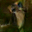

In [11]:
images[0]

In [33]:
import math
from typing import List, Optional, Tuple, Union

import torch
from diffusers import DiffusionPipeline, ImagePipelineOutput, UNet2DModel
from diffusers.utils import randn_tensor


class ConsistencyPipeline2(DiffusionPipeline):
    unet: UNet2DModel

    def __init__(
        self,
        unet: UNet2DModel,
    ) -> None:
        super().__init__()
        self.register_modules(unet=unet)

    @torch.no_grad()
    def __call__(
        self,
        steps: int = 1,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        time_min: float = 0.002,
        time_max: float = 80.0,
        data_std: float = 0.5,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        **kwargs,
    ) -> Union[Tuple, ImagePipelineOutput]:
        img_size = self.unet.config.sample_size
        shape = (1, 3, img_size, img_size)

        model = self.unet

        time: float = time_max

        # sample = randn_tensor(shape, generator=generator, device=self.device) * time

        # for step in self.progress_bar(range(steps)):
        #     if step > 0:
        #         time = self.search_previous_time(time)
        #         sigma = math.sqrt(time**2 - time_min**2 + 1e-6)
        #         sample = sample + sigma * randn_tensor(sample.shape, device=self.device, generator=generator)

        #     out = model(sample, torch.tensor([time], device=self.device)).sample

        #     skip_coef = data_std**2 / ((time - time_min) ** 2 + data_std**2)
        #     out_coef = data_std * time / (time**2 + data_std**2) ** (0.5)

        #     sample = (sample * skip_coef + out * out_coef).clamp(-1.0, 1.0)

        # sample = (sample / 2 + 0.5).clamp(0, 1)
        # image = sample.cpu().permute(0, 2, 3, 1).numpy()

        # if output_type == "pil":
        #     image = self.numpy_to_pil(image)

        # if not return_dict:
        #     return (image,)

        # return ImagePipelineOutput(images=image)

        sample1 = randn_tensor(shape, generator=generator, device=self.device) * time
        sample2 = randn_tensor(shape, generator=generator, device=self.device) * time
        # sample3 = randn_tensor(shape, generator=generator, device=self.device) * time / 10
       



        height = sample1.shape[2]
        top_half, _ = torch.split(sample1, height // 2, dim=2)
        _, bottom_half = torch.split(sample2, height // 2, dim=2)

        # Concatenate the top half of sample1 with the bottom half of sample2
        sample_merge = torch.cat([top_half, bottom_half], dim=2)
        # sample_merge = sample1 + sample3

        samples = [sample1, sample2, sample_merge]
        outs = []

        for step in self.progress_bar(range(steps)):
            if step > 0:
                time = self.search_previous_time(time)
                sigma = math.sqrt(time**2 - time_min**2 + 1e-6)

            
            for sample in samples:
                out = model(sample, torch.tensor([time], device=self.device)).sample

                skip_coef = data_std**2 / ((time - time_min) ** 2 + data_std**2)
                out_coef = data_std * time / (time**2 + data_std**2) ** (0.5)

                sample = (sample * skip_coef + out * out_coef).clamp(-1.0, 1.0)
                outs.append(sample)

        images = []

        for sample in outs:
            sample = (sample / 2 + 0.5).clamp(0, 1)
            image = sample.cpu().permute(0, 2, 3, 1).numpy()

            if output_type == "pil":
                image = self.numpy_to_pil(image)
            images.append(image)
            


        if not return_dict:
            return (images,)

        return ImagePipelineOutput(images=images)

    def search_previous_time(self, time, time_min: float = 0.002, time_max: float = 80.0):
        return (2 * time + time_min) / 3

    def cuda(self):
        self.to("cuda")


In [39]:
pipeline = ConsistencyPipeline2.from_pretrained(
    "consistency/cifar10-32-demo",
)

images = pipeline().images

unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/zw2599/miniconda3/envs/sd_playground/lib/python3.8/site-packages/diffusers/models/resnet.py:409: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(kernel, device=hidden_states.device),
/home/zw2599/miniconda3/envs/sd_playground/lib/python3.8/site-packages/diffusers/models/resnet.py:322: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(kernel, device=hidden_states.device),


In [43]:
images = []
for i in range(5):
    image = pipeline().images
    images.append(image)

  0%|          | 0/1 [00:00<?, ?it/s]

/home/zw2599/miniconda3/envs/sd_playground/lib/python3.8/site-packages/diffusers/models/resnet.py:409: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(kernel, device=hidden_states.device),
/home/zw2599/miniconda3/envs/sd_playground/lib/python3.8/site-packages/diffusers/models/resnet.py:322: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(kernel, device=hidden_states.device),


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

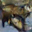

In [83]:
images[1][0][0]

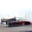

In [84]:
images[1][1][0]

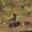

In [85]:
images[1][2][0]

In [ ]:
images[2][0]==images[0][0]

False

In [1]:
from diffusers import DDPMPipeline

generator = DDPMPipeline.from_pretrained("anton-l/ddpm-butterflies-128", use_safetensors=True)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
image = generator().images

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

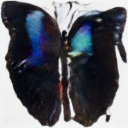

In [7]:
image[0][0]

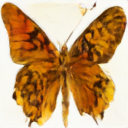

In [8]:
image[1][0]

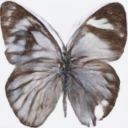

In [9]:
image[2][0]